# Course 2 - Final Project - Dan Dumitru Damian

This is the implemetation of the final project made by Dan Damian starting from the lab notepad from the last week of this course.

First import the libraries required for this project

In [38]:
import pandas as pd
import numpy as np
import gc
import math
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
import xgboost as xgb
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from math import ceil
from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Load data subset

Load the data from the hard drive... Data files must be in a data/ subfolder relatively to the folder where notepad is installed

In [2]:
sales = pd.read_csv('data/sales_train_v2.csv')
shops = pd.read_csv('data/shops.csv')
items = pd.read_csv('data/items.csv')
item_cats = pd.read_csv('data/item_categories.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/test.csv')

Remove the training data for shops and items that are not in the test set

In [3]:
sales = sales[sales['shop_id'].isin(sorted(test.shop_id.unique()))]
sales = sales[sales['item_id'].isin(sorted(test.item_id.unique()))]

In [4]:
sales.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
10,03.01.2013,0,25,2574,399.0,2.0
11,05.01.2013,0,25,2574,399.0,1.0
12,07.01.2013,0,25,2574,399.0,1.0
13,08.01.2013,0,25,2574,399.0,2.0
14,10.01.2013,0,25,2574,399.0,1.0
15,11.01.2013,0,25,2574,399.0,2.0
16,13.01.2013,0,25,2574,399.0,1.0
17,16.01.2013,0,25,2574,399.0,1.0
18,26.01.2013,0,25,2574,399.0,1.0


# EDA

Show sales per month for each shop, to discover the time trends for shops sales

/Users/dandamian/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


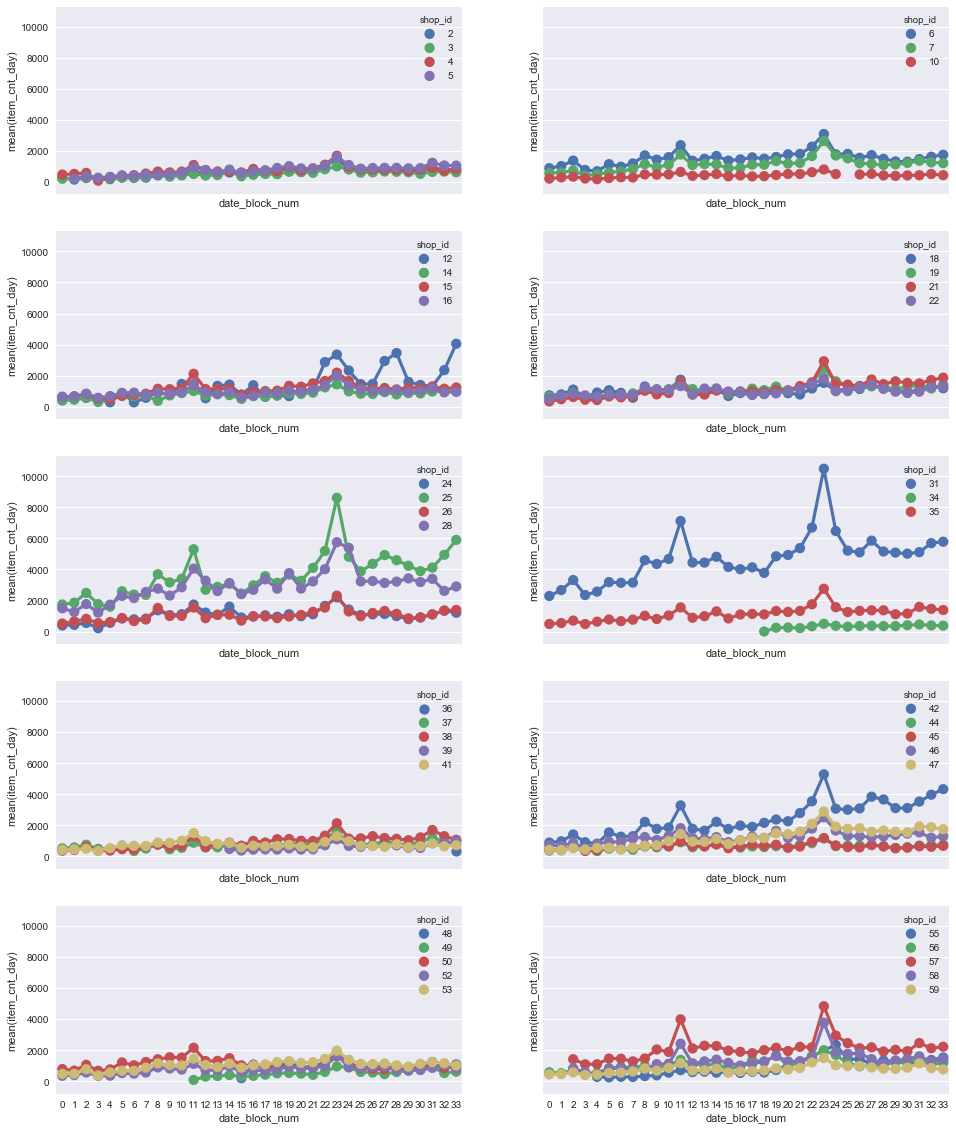

In [39]:
grouped = pd.DataFrame(sales.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

Display sales per day distribution

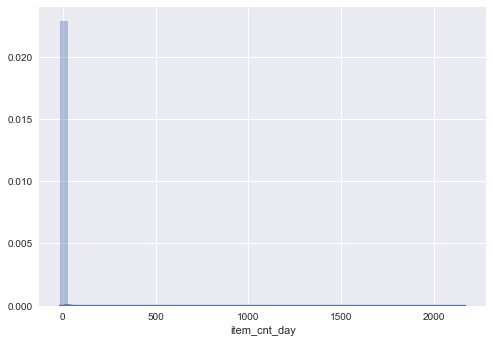

In [40]:
sns.distplot(sales['item_cnt_day']);

# Create the feature matrix

### Monthly sales calculation

Calculate number of sales per month for all item/shop pairs and for each shop and all iteams, as well as each item for any shop.

In [5]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

/Users/dandamian/anaconda/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [6]:
all_data.head(10)

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,59,22154,0,1.0,452.0,16.0
1,59,2574,0,2.0,452.0,84.0
2,59,2607,0,0.0,452.0,18.0
3,59,2614,0,0.0,452.0,16.0
4,59,2808,0,15.0,452.0,689.0
5,59,2703,0,0.0,452.0,55.0
6,59,2088,0,0.0,452.0,1.0
7,59,2090,0,0.0,452.0,14.0
8,59,2100,0,1.0,452.0,16.0
9,59,2164,0,0.0,452.0,2.0


Clip the number of sales per month in whole training data to 0.,20. interval

In [7]:
all_data.loc[(all_data['target'] > 20.), 'target']=20.
all_data.loc[(all_data['target'] <  0.), 'target']= 0.

Append the test data at the end of the all_data data frame, month 34th and remove the ID column

In [8]:
test['date_block_num']=34
test['target']=0
test['target_shop']=0
test['target_item']=0
del test['ID']

In [9]:
print('The length of the test dataframe is', len(test))

The length of the test dataframe is 214200


In [10]:
all_data = pd.concat([all_data, test], ignore_index=True)

In [11]:
print('The length of the all_data dataframe is', len(all_data))

The length of the all_data dataframe is 2946018


### Create past months sales features

In [12]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
cols_to_rename = ['target', 'target_item', 'target_shop']

After creating a grid, we can calculate some features. We will use lags from [1, 2, 3, 4, 5, 12] months ago.

In [13]:
# past month langs to be calculated
shift_range = [1, 2, 3, 5, 12]


In [14]:
for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

In [15]:
# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] + ['item_category_id']
print('Corlumns used for fitting models :', fit_cols)
# We will drop these at fitting stage
print('')
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 
print('Corlumns to be dropped before fitting models :', to_drop_cols)


Corlumns used for fitting models : ['target_lag_1', 'target_item_lag_1', 'target_shop_lag_1', 'target_lag_2', 'target_item_lag_2', 'target_shop_lag_2', 'target_lag_3', 'target_item_lag_3', 'target_shop_lag_3', 'target_lag_5', 'target_item_lag_5', 'target_shop_lag_5', 'target_lag_12', 'target_item_lag_12', 'target_shop_lag_12', 'item_category_id']

Corlumns to be dropped before fitting models : ['target_shop', 'target', 'target_item', 'date_block_num']


In [16]:
all_data.head(10)

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,59,22154,0,1.0,452.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,59,2574,0,2.0,452.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
2,59,2607,0,0.0,452.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
3,59,2614,0,0.0,452.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
4,59,2808,0,15.0,452.0,689.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30
5,59,2703,0,0.0,452.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30
6,59,2088,0,0.0,452.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58
7,59,2090,0,0.0,452.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
8,59,2100,0,1.0,452.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
9,59,2164,0,0.0,452.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58


# Train/Validation/Test split

For a sake of the programming assignment, let's artificially split the data into train and test. We will treat last month data as the test set.

In [17]:
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

test_block = 34  # The test data is from month 34th
val_block = 33   # Validation data will be the last month from the training data
print('Test set month is %d' % test_block)
print('Validation set month is %d' % val_block)

Test set month is 34
Validation set month is 33


# First level models 

We use first level models to build two datasets: validation set meta-features, test set meta-features and 2-nd level train-metafetures.

In [18]:
dates_train = dates[dates <  val_block]
dates_val  = dates[dates == val_block]

X_train = all_data.loc[dates <  val_block].drop(to_drop_cols, axis=1)
X_val =  all_data.loc[dates == val_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == test_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  val_block, 'target'].values
y_val  =  all_data.loc[dates == val_block, 'target'].values

### Validation set an Test set meta-features

Firts, we will run *linear regression* on numeric columns and get predictions for the last two months.

In [19]:
lr = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0])
lr.fit(X_train.values, y_train)
pred_train_lr = lr.predict(X_train.values).clip(0.,20.)
pred_val_lr = lr.predict(X_val.values).clip(0.,20.)
pred_test_lr = lr.predict(X_test.values) .clip(0.,20.)

print('     Train set RMSE for linreg is %f' % math.sqrt(mean_squared_error(y_train, pred_train_lr)))
print('Validation set RMSE for linreg is %f' % math.sqrt(mean_squared_error(y_val, pred_val_lr)))

     Train set RMSE for linreg is 2.375848
Validation set RMSE for linreg is 2.264185


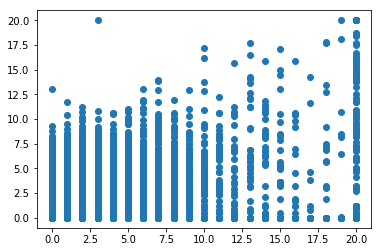

In [20]:
plt.scatter(y_val, pred_val_lr)

And the we run *LightGBM*.

In [21]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**8, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**8, 
               'num_leaves': 2**8,
               'bagging_freq':1,
               'verbose':0 
              }

model_lgb = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_train_lgb = model_lgb.predict(X_train).clip(0.,20.)
pred_val_lgb = model_lgb.predict(X_val).clip(0.,20.)
pred_test_lgb = model_lgb.predict(X_test).clip(0.,20.)

print('Training set RMSE for LightGBM is %f' % math.sqrt(mean_squared_error(y_train, pred_train_lgb)))
print('Validation set RMSE for LightGBM is %f' % math.sqrt(mean_squared_error(y_val, pred_val_lgb)))

Training set RMSE for LightGBM is 1.043423
Validation set RMSE for LightGBM is 0.945923


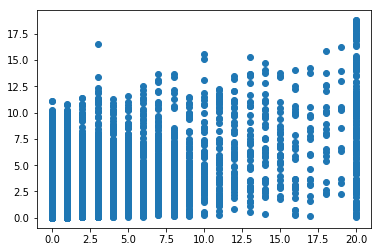

In [22]:
plt.scatter(y_val, pred_val_lgb)

Concatenate validation set predictions to get validation set meta-features.

In [23]:
X_val_level2 = np.c_[pred_val_lr, pred_val_lgb] 

In [24]:
print('X_val_level2.shape is ', X_val_level2.shape)
print('y_val.shape is ', y_val.shape)

X_val_level2.shape is  (166110, 2)
y_val.shape is  (166110,)


Concatenate test set predictions to get test set meta-features

In [25]:
X_test_level2 = np.c_[pred_test_lr, pred_test_lgb] 

In [26]:
print('X_test_level2.shape is ', X_test_level2.shape)

X_test_level2.shape is  (214200, 2)


### Train meta-features

Calculate predictions (meta-features) from *linear regression* and *LightGBM* for months 27, 28, 29, 30, 31, 32. Use the same parameters as in above models.

In [27]:
train_months = [27, 28, 29, 30, 31, 32]

dates_train_level2 = dates_train[dates_train.isin(train_months)]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin(train_months)]
print(y_train_level2.shape)

(796548,)


In [28]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])
print(X_train_level2.shape)

l1=0
l2=0

# Now fill `X_train_level2` with metafeatures
for cur_block_num in tqdm_notebook(train_months):
    
    dates_train = dates[dates <  cur_block_num]
    dates_val  = dates[dates == cur_block_num]

    X_train = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
    X_val   = all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)

    y_train = all_data.loc[dates <  cur_block_num, 'target'].values
    #y_test =  all_data.loc[dates == cur_block_num, 'target'].values  
    
    lr.fit(X_train.values, y_train)
    pred_lr = lr.predict(X_val.values)

    model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
    pred_lgb = model.predict(X_val)
    
    X_train_l_2 = np.c_[pred_lr, pred_lgb] 
    l1=l2
    l2=l1 + X_train_l_2.shape[0]
    X_train_level2[l1:l2,:]=X_train_l_2


(796548, 2)


# Ensembling

Now, when the meta-features are created, we can ensemble our first level models.

### Stacking

Fit a linear regression model to the meta-features. Use the same parameters as in the model above.

In [29]:
from sklearn import linear_model
#meta_model = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0])
meta_model = linear_model.LinearRegression(n_jobs=10)
meta_model.fit(X_train_level2, y_train_level2)

/Users/dandamian/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=10, normalize=False)

Compute R-squared on the train and test sets and also the test set predictions

In [30]:
train_preds = meta_model.predict(X_train_level2).clip(0.,20.) 
rmse_train_stacking = math.sqrt(mean_squared_error(y_train_level2, train_preds))

stack_val_preds = meta_model.predict(X_val_level2).clip(0.,20.) 
stack_test_preds = meta_model.predict(X_test_level2).clip(0.,20.) 

rmse_val_stacking= math.sqrt(mean_squared_error(y_val, stack_val_preds))

print('Train  RMSE for stacking is %f' % rmse_train_stacking)
print('-------------')
print('Validation set RMSE for stacking is %f' % rmse_val_stacking)

Train  RMSE for stacking is 0.958912
-------------
Validation set RMSE for stacking is 0.940022


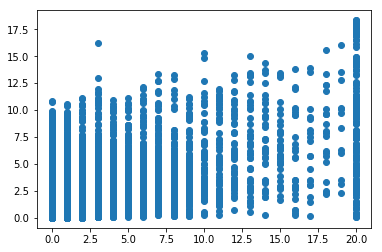

In [31]:
plt.scatter(y_val, stack_val_preds)

# Prepare submission file

Choose the test predictions from the best ensembling method

In [32]:
test_preds = stack_test_preds

In [33]:
submission['target'] = test_preds

In [34]:
submission.to_csv("Submissions/submission.csv", 
                  columns=['ID', 'target'], 
                  header = ['ID', 'item_cnt_month'], 
                  index=False)